### 卷积层
卷积的特性：

    1. 局部感知机制

    2. 权值共享

卷积的目的：对图像特征进行提取

卷积核的 `channel`与输入特征层的`channel`相同

输出矩阵`channel`与卷积核个数相同

卷积越界：在图像边缘进行补零操作(padding)

经过卷积后的矩阵尺寸大小：$(W-F+2P)/S+1$
   - 输入图片：$W*W$
   - Filter大小：$F*F$
   - 步长：$S$
   - padding 的像素：$P$

### 池化层

目的：对特征图进行稀疏处理,减少数据运算量

特点：

1. 没有训练参数
2. 只改变特征矩阵的`w`和`h`,不改变`channel`
3. 一般`poolsize`和`stride`一样

## BP

### 梯度 

### 权重更新

因为实际应用中不能将所有数据一次载入内存计算，所以常常使用分批次训练，别去损失梯度指向当前批次最优方向

优化器（optimazer）：使网络更快的收敛

1. SGD:

$$ w_{t+1} = w_{t}-\alpha*g(w_{t})$$

## 搭建LeNet

### 使用LeNet来进行预测

In [77]:
import torch
import os
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time

# 数据转换
trans = torchvision.transforms.Compose([transforms.ToTensor(),
                                       # 标准化：output=(input-0.5)/0.5
                                        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                       ])
# 训练数据
train_dataset = torchvision.datasets.CIFAR10('../dataset/data',download=True,transform=trans,
                                      train=True)

# 测试数据
test_dataset = torchvision.datasets.CIFAR10('../dataset/data',download=True,transform=trans,
                                      train=False)

# 载入数据集
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size = 64,shuffle=True)
# 测试数据载入,使用了迭代器，故一个batch_size 是 10000(所有数据)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size = 10000,shuffle=True)

print("训练测试集数据数量:",len(train_dataset))
print("验证测试集数据数量:",len(test_dataset))


# 类别标签(10类)==>元组，不可更改
classes =('plane','car','bird','cat',
         'deer','dog','forg','horse','ship','truck')
# 可迭代的迭代器
test_data_iter=iter(testloader)
test_image,test_label = test_data_iter.next()


# 反标准化
# input=output*0.5+0.5=output/2+0.5

# 显示图片
def img_show(img):
    img = img/2 +0.5 # unnormalize
    # 将图像更改为 numpy 类型
    np_img = img.numpy()
    # 将图像的 c，h，w 进行更改为原始格式
    plt.imshow(np.transpose(np_img,(1,2,0)))
    plt.show

# 显示图片    
# img_show(torchvision.utils.make_grid(test_image))
# # 显示标签
# # 每隔 8 个加上换行符
# print(' '.join('%5s' %classes[test_label[j]] for j in range(64)))


# 定义 LeNet网络
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet,self).__init__()
        # （32-5）+1 =28
        self.conv1 = nn.Conv2d(3,16,kernel_size=5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*5*5,120)
        self.fc2 = nn.Linear(120,84)
        # 具有十个类别的训练集，所以输出 10
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = F.relu(self.conv1(x)) # input(3,32,32) output(16,28,28)
        x = self.pool1(x) # output(16,14,14)
        x = F.relu(self.conv2(x)) # output(32,10,10)
        x = self.pool2(x) # output(32,5,5)
        # 更改矩阵形状
        x = x.view(-1,32*5*5)    # output(32*5*5)
        x = F.relu(self.fc1(x)) # output(120)
        x = F.relu(self.fc2(x)) # output(84)
        x = self.fc3(x)          # output(10)
        return x
# 网络
lenet = Lenet()
# 损失函数
loss_fn = nn.CrossEntropyLoss()
# 优化器
optimizer = optim.Adam(lenet.parameters(),lr=0.001)

'''测试网络的准确性
x= torch.ones(32*32*3).reshape(3,32,32)
print(lenet)
print(lenet(x).shape)
'''

# 将图像通过 tensorboard 进行输出
writer = SummaryWriter('../log/LeNet_log')
print("======使用 CPU 训练======")
# 对数据批处理

epoch = 5
for i in range(epoch):
    running_loss = 0.0
    stime = time.time()
    print('------第 {} 次处理------'.format(i+1))
    for step ,data in enumerate(trainloader,start=0):
        inputs ,labels = data
        
        # 损失梯度清零(也可以保留，多batch的累加之后一次清除)
        optimizer.zero_grad()
        # 运行网络,优化
        outputs = lenet(inputs)
        # 将输出与标签值进行对比来获取损失值
        loss = loss_fn(outputs,labels)
        # 反向传播
        loss.backward()
        # 优化，参数更新
        optimizer.step()
        # 一个 batch 中的损失的叠加
        running_loss += loss.item()
        # 每过 300 次进行一次输出(step 从零开始所以是整除为499)
        if step % 300 == 299:
            with torch.no_grad():
                outputs = lenet(test_image) # [batch,10] 
#                 print(outputs)
#                 print(outputs.shape)
#                 break
               # print()
                # 在输出的第 1个维度(类别)查找最大值==>标签类别
                predict_y = torch.max(outputs,dim=1)[1]
                # 计算准确性
                accuarcy = (predict_y == test_label).sum().item() / test_label.size(0)
                
                print('[%3d] train_loss: %.3f test_accuracy :%.3f'%(step+1,running_loss /500,accuarcy))
                # 损失值置零
                running_loss = 0.0
    print('train time: {} ms'.format(time.time() - stime))
                
print('Finish Training')

# 保存模型
# 获取上一层目录
curpath = os.path.abspath(os.path.dirname(os.getcwd()))
path = '/net_model/lenet_cpu.pth'
model_cpu_path = curpath + path
torch.save(lenet.state_dict(),model_path)

print('网络模型 LeNet 已经保存至 {}'.format(model_cpu_path))

Files already downloaded and verified
Files already downloaded and verified
训练测试集数据数量: 50000
验证测试集数据数量: 10000
======使用 CPU 训练======
------第 1 次处理------
[300] train_loss: 1.059 test_accuracy :0.435
[600] train_loss: 0.877 test_accuracy :0.505
train time: 15.081732749938965 ms
------第 2 次处理------
[300] train_loss: 0.769 test_accuracy :0.558
[600] train_loss: 0.722 test_accuracy :0.555
train time: 19.75468111038208 ms
------第 3 次处理------
[300] train_loss: 0.660 test_accuracy :0.597
[600] train_loss: 0.629 test_accuracy :0.624
train time: 19.13700556755066 ms
------第 4 次处理------
[300] train_loss: 0.579 test_accuracy :0.637
[600] train_loss: 0.573 test_accuracy :0.644
train time: 19.407701015472412 ms
------第 5 次处理------
[300] train_loss: 0.535 test_accuracy :0.659
[600] train_loss: 0.530 test_accuracy :0.658
train time: 15.611768960952759 ms
Finish Training
网络模型 LeNet 已经保存至 /home/yy/Project/net_model/lenet_cpu.pth


In [110]:
import torch
import os
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time
# 选择训练方式
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('训练设备:',device)

# 数据转换
trans = torchvision.transforms.Compose([transforms.ToTensor(),
                                       # 标准化：output=(input-0.5)/0.5
                                        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                       ])
# 训练数据
train_dataset = torchvision.datasets.CIFAR10('../dataset/data',download=True,transform=trans,
                                      train=True)

# 测试数据
test_dataset = torchvision.datasets.CIFAR10('../dataset/data',download=True,transform=trans,
                                      train=False)

# 载入数据集
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size = 64,shuffle=True)
# 测试数据载入,使用了迭代器，故一个batch_size 是 10000(所有数据)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size = 10000,shuffle=True)

print("训练测试集数据数量:",len(train_dataset))
print("验证测试集数据数量:",len(test_dataset))


# 类别标签(10类)==>元组，不可更改
# classes =('plane','car','bird','cat',
#          'deer','dog','forg','horse','ship','truck')

classes = train_dataset.class_to_idx
classes = dict((val,key) for key ,val in classes.items())
print(classes)
# 可迭代的迭代器
test_data_iter=iter(testloader)
test_image,test_label = test_data_iter.next()

# 反标准化
# input=output*0.5+0.5=output/2+0.5

# 显示图片
def img_show(img):
    img = img/2 +0.5 # unnormalize
    # 将图像更改为 numpy 类型
    np_img = img.numpy()
    # 将图像的 c，h，w 进行更改为原始格式
    plt.imshow(np.transpose(np_img,(1,2,0)))
    plt.show

# 显示图片    
# img_show(torchvision.utils.make_grid(test_image))
# # 显示标签
# # 每隔 8 个加上换行符
# print(' '.join('%5s' %classes[test_label[j]] for j in range(64)))


# 定义 LeNet网络
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet,self).__init__()
        # （32-5）+1 =28
        self.conv1 = nn.Conv2d(3,16,kernel_size=5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*5*5,120)
        self.fc2 = nn.Linear(120,84)
        # 具有十个类别的训练集，所以输出 10
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = F.relu(self.conv1(x)) # input(3,32,32) output(16,28,28)
        x = self.pool1(x) # output(16,14,14)
        x = F.relu(self.conv2(x)) # output(32,10,10)
        x = self.pool2(x) # output(32,5,5)
        # 更改矩阵形状
        x = x.view(-1,32*5*5)    # output(32*5*5)
        x = F.relu(self.fc1(x)) # output(120)
        x = F.relu(self.fc2(x)) # output(84)
        x = self.fc3(x)          # output(10)
        return x
# 网络
lenet = Lenet()
lenet = lenet.to(device)
# 损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
# 优化器
optimizer = optim.Adam(lenet.parameters(),lr=0.001)

'''测试网络的准确性
x= torch.ones(32*32*3).reshape(3,32,32)
print(lenet)
print(lenet(x).shape)
'''

# 将图像通过 tensorboard 进行输出
writer = SummaryWriter('../log/LeNet_log')
print("======使用 GPU 训练======")
# 对数据批处理

epoch = 5
for i in range(epoch):
    running_loss = 0.0
    stime = time.time()
    print('------第 {} 次处理------'.format(i+1))
    for step ,data in enumerate(trainloader,start=0):
        inputs ,labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 损失梯度清零(也可以保留，多batch的累加之后一次清除)
        optimizer.zero_grad()
        # 运行网络,优化
        outputs = lenet(inputs)
        # 将输出与标签值进行对比来获取损失值
        loss = loss_fn(outputs,labels)
        # 反向传播
        loss.backward()
        # 优化，参数更新
        optimizer.step()
        # 一个 batch 中的损失的叠加
        running_loss += loss.item()
        # 每过 300 次进行一次输出(step 从零开始所以是整除为499)
        if step % 300 == 299:
            with torch.no_grad():
                test_image = test_image.to(device)
                test_label = test_label.to(device)
                outputs = lenet(test_image) # [batch,10] 
               
        #          print(outputs)
        #         print(outputs.shape)
        #         break
               # print()
                # 在输出的第 1个维度(类别)查找最大值==>标签类别
                predict_y = torch.max(outputs,dim=1)[1]
                predict_y = predict_y.to(device)
                # 计算准确性
                accuarcy = (predict_y == test_label).sum().item()/ test_label.size(0)
                
                print('[%3d] train_loss: %.3f test_accuracy :%.3f'%(step+1,running_loss /500,accuarcy))
                # 损失值置零
                running_loss = 0.0
    print('train time: {} ms'.format(time.time() - stime))
print('Finish Training')

# 保存模型
# 获取上一层目录
curpath = os.path.abspath(os.path.dirname(os.getcwd()))
path = '/net_model/lenet_gpu.pth'
model_gpu_path = curpath + path
torch.save(lenet.state_dict(),model_path)

print('网络模型 LeNet 已经保存至 {}'.format(model_gpu_path))

训练设备: cuda:0
Files already downloaded and verified
Files already downloaded and verified
训练测试集数据数量: 50000
验证测试集数据数量: 10000
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
======使用 GPU 训练======
------第 1 次处理------
[300] train_loss: 1.076 test_accuracy :0.441
[600] train_loss: 0.874 test_accuracy :0.507
train time: 8.70850658416748 ms
------第 2 次处理------
[300] train_loss: 0.767 test_accuracy :0.562
[600] train_loss: 0.723 test_accuracy :0.573
train time: 8.220105648040771 ms
------第 3 次处理------
[300] train_loss: 0.657 test_accuracy :0.603
[600] train_loss: 0.642 test_accuracy :0.620
train time: 8.4958815574646 ms
------第 4 次处理------
[300] train_loss: 0.582 test_accuracy :0.646
[600] train_loss: 0.574 test_accuracy :0.633
train time: 8.363420724868774 ms
------第 5 次处理------
[300] train_loss: 0.527 test_accuracy :0.660
[600] train_loss: 0.537 test_accuracy :0.658
train time: 8.38969349861145 ms
Finish Training
网络模型 Le

tensor([[-5.0962, -6.2121, -0.2277, -1.0696,  5.7888,  2.2162, -0.5955,  4.8585,
         -7.8263, -6.4763]])
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
predict: deer


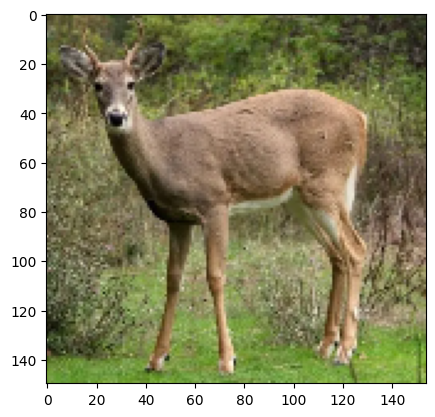

In [251]:
from PIL import Image
import matplotlib.pyplot as plt

img_path ='../image/deer.png'
# 因为输入的图片是 RGBA 的格式，要将其转换为 RGB 格式然后进行操作
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
# 格式转变
trans = transforms.Compose([    
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    # 在训练过程中有预处理，所以在输入的图片也需要预处理
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

img = trans(img) # [C,H,W]

# 将图片进行拓展,在最前面增加一个维度
img = torch.unsqueeze(img,dim=0) # [N,C,H,W]  [1, 3, 32, 32]
# 载入已经训练的模型
net = Lenet()
net.load_state_dict(torch.load(model_path))

# 不需要求损失梯度(加快运行速度)
with torch.no_grad():
    outputs = net(img)
    print(outputs)
    print(classes)
    # 通过 max 函数的输出有两个值：indices和 value,通过indices来指定标签的位置的对象
    #predict = torch.max(outputs,dim=1)[1].data.numpy()
    predict = torch.max(outputs,dim=1)[1]
print("predict:",classes[int(predict)])
plt.show()
#print(classes[predict])

### AlexNet

网络的亮点：
1. 首次使用 $GPU$ 进行网络加速训练
2. 使用了 $ReLU$ 函数 替代了传统的$Sigmoid$激活函数(求导麻烦，网络深的时候梯度消失)
3. 使用了$LRN$局部响应归一化
4. 在全连接层的前两层中使用了$Dropout$随机失活神经元操作，以减少过拟合

---
|网络层|kernel_size|kernel|stride|padding|
|---|---|---|---|---|
|Conv1|11|96|[1,2]|4|
|Maxpool1|3|None|0|2|
|Conv2|5|256|[2,2]|1|
|Maxpool2|3|None|0|2|
|Conv3|3|384|[1,1]|1|
|Conv4|3|384|[1,1]|1|
|Conv5|3|256|[1,1]|1|
|Maxpool3|3|None|0|2|
|FC1|2048|None|None|None|
|FC2|2048|None|None|None|
|FC3|1000|None|None|None|


In [163]:
# 定义 AlexNet
class Alexnet(nn.Module):
    def __init__(self,num_classes=10,init_weights=False):
        super(Alexnet,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,48,kernel_size=11,stride=4,padding=2), # input[3,224,224] output [48,55,55]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),               # output [48,27,27]
            nn.Conv2d(48,128,kernel_size=5,padding=2),          # output [128,27,27]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),               # output[128,13,13]
            nn.Conv2d(128,192,kernel_size=3,padding=1),         # output[192,13,13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192,192,kernel_size=3,padding=1),        # output[192,13,13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192,128,kernel_size=3,padding=1),        # output[128,13,13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),              # output[128,6,6]
        )
        self.classifiter = nn.Sequential(
            # p 为随机失活的概率(50%)
            nn.Dropout(p = 0.5),
            nn.Linear(128 * 6 * 6,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048,2048),
            nn.ReLU(inplace=True),
            # 线性层，输出的大小为要训练的类别数
            nn.Linear(2048,num_classes)
        )
        # 初始化权重
        if init_weights:
            self._initialize_weigts()
    def forward(self,x):
        x = self.model(x)
        # 从 channel 开始展平
        x = torch.flatten(x,start_dim=1)
        x = self.classifiter(x)
        return x
    
    def _initialize_weigts(self):
        # 迭代定义网络的所有层结构
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
                # 偏置不为空，用零赋值
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                # [tensor , mean,std],给定均值和标准差的正态分布,填充张量
                nn.init.normal_(m.weight,0,0.01)
                nn.init.constant_(m.bias,0)
# 输出类别为 5
net = Alexnet(num_classes=5)
x = torch.ones(3*224*224).reshape(3,224,224)
# 增加一个维度用于存储batch_size
x = torch.unsqueeze(x,dim=0)
print(x.shape)
print(net(x).shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 5])


### 测试网络

训练数据量： 3306
tulips sunflowers tulips sunflowers
100%|███████████████████████████████████████████████████████████████████████████████████| 91/91 [00:02<00:00, 42.54it/s]
[epoch: 1] train_loss: 1.365 test_accuracy: 0.442
100%|███████████████████████████████████████████████████████████████████████████████████| 91/91 [00:02<00:00, 44.07it/s]
[epoch: 2] train_loss: 1.192 test_accuracy: 0.489
100%|███████████████████████████████████████████████████████████████████████████████████| 91/91 [00:02<00:00, 44.41it/s]
[epoch: 3] train_loss: 1.097 test_accuracy: 0.624
100%|███████████████████████████████████████████████████████████████████████████████████| 91/91 [00:02<00:00, 42.87it/s]
[epoch: 4] train_loss: 1.016 test_accuracy: 0.593
100%|███████████████████████████████████████████████████████████████████████████████████| 91/91 [00:02<00:00, 41.73it/s]
[epoch: 5] train_loss: 0.995 test_accuracy: 0.659
100%|███████████████████████████████████████████████████████████████████████████████████| 91/91 [

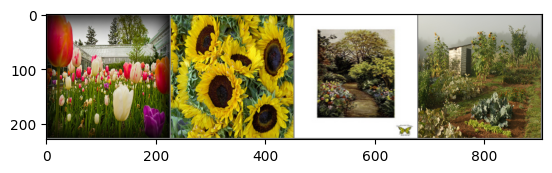

In [164]:
import torchvision.datasets as datasets
from torchvision import transforms,datasets,utils
import json
import time
import sys
from tqdm import tqdm # 进度条
# 选择 GPU 训练(有显卡用显卡，无显卡用 CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)
# 根据要求调整输入图片的格式(训练/验证)
trans = {
    'train':transforms.Compose([
                                transforms.ToTensor(),
                                # 随机裁剪
                                transforms.RandomResizedCrop(224),
                                # 随机翻转
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                 ]),
    'val':transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((224,224)), # 必须指定为 (224,224)
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                 ])
}

# 获取数据集的根目录
data_root = os.path.abspath(os.path.join(os.getcwd(),'../dataset/'))
img_path = data_root+'/flower_data/'

train_dataset = datasets.ImageFolder(root = img_path+'/train',
                                    transform = trans['train'])
train_num = len(train_dataset)
print('训练数据量：',train_num)
# {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
flower_list = train_dataset.class_to_idx # 获取分类名称的索引
# 改变 键值对
class_dict = dict((val,key) for key,val in flower_list.items())
# 通过 json 文件记录键值对信息
json_strt = json.dumps(class_dict,indent=4)
with open('class_indices.json','w') as json_file:
    json_file.write(json_strt)
    
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

# 验证
val_dataset = datasets.ImageFolder(root = img_path+'/val',
                                  transform=trans['val'])
val_num = len(val_dataset)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=0)

# 测试数据集的迭代
test_data_iter = iter(val_loader)
test_img,test_label = test_data_iter.next()


print(' '.join('%5s' %class_dict[test_label[j].item()] for j in range(4)))
img_show(utils.make_grid(test_img))

# 选择网络
net = Alexnet(num_classes=5,init_weights=True)
net = net.to(device)
# 损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
# 优化
optimizer = optim.Adam(net.parameters(),lr=0.0002)

save_path = '../net_model/alexnet.pth'
# 最佳准确率
best_acc = 0.0
epochs = 10
for epoch in range(epochs):
    # 通过网络的 train/eval 来划分训练和测试，以达到不同功能的不同方法
    net.train()
    running_loss =0.0
    # 记录训练一个 epoch 所需的时间
    t1 = time.perf_counter()
    train_bar = tqdm(train_loader,file=sys.stdout) # 训练进度条
    for step,data in enumerate(train_bar):
        images,labels = data
        optimizer.zero_grad()

        # 调用 CPU/GPU 来进行运算
        # print(images.shape)
        # images = torch.unsqueeze(images,0)
        # print(images.shape)
        outputs = net(images.to(device))
        
        #outputs = net(images)
        loss = loss_fn(outputs,labels.to(device))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # 训练率
        rate = (step+1)/len(train_loader)
        a = '*'*int(rate*50)
        b = '.'*int((1-rate)*50)
        # 输出训练进度
        print('\rtrain loss:{:^3.0f}%[{}->{}]{:.3f}'.format(int(rate*100),a,b,loss),end='')
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                    loss)
    net.eval()
    acc = 0.0 #
    with torch.no_grad():  # 验证过程不记录梯度(节省资源)
        # 验证进度条(在标准输出写进度)
        val_bar = tqdm(val_loader,file=sys.stdout)
        for val_data in  val_bar:
            test_images,test_labels = val_data
            if torch.cuda.is_available:
                test_images = test_images.to(device)
            outputs = net(test_images)
            predict_y = torch.max(outputs,dim=1)[1]
            acc += (predict_y == test_labels.to(device)).sum().item()
        # 测试准确率    
        accurate_test = acc/val_num
        if accurate_test > best_acc:
            best_acc = accurate_test
            torch.save(net.state_dict(),save_path)
        print('[epoch: %d] train_loss: %.3f test_accuracy: %.3f'%(epoch+1,running_loss/step,
                                                                 accurate_test))        
print('Finish Training')

### 验证 AlexNet网络




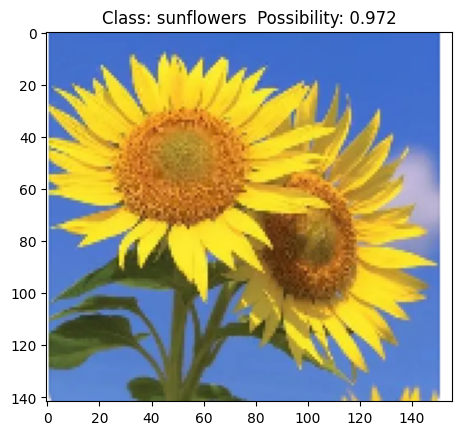

class: daisy        Possibility: 0.000153
class: dandelion    Possibility: 0.0227
class: roses        Possibility: 0.000171
class: sunflowers   Possibility: 0.972
class: tulips       Possibility: 0.00449


In [242]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

img_path = '../image/sunflower.png'
img = Image.open(img_path).convert('RGB')


trans_mode = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((224,224)),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# 显示要训练的图像
plt.imshow(img)
# 图像格式转换
img = trans_mode(img)
# 图像增加一个维度
img = torch.unsqueeze(img,dim=0)


# 读取类别的 json 文件
# 判断json文件是否存在
json_path = './class_indices.json'
assert os.path.exists(json_path),'file:{} do not exist'.format(json_path)

# 读取类别

with open(json_path,'r') as index:
    class_indict = json.load(index)
# print(class_indict)
# 载入模型权重
model = Alexnet(num_classes=5).to(device)
# 字典形式载入网络
model.load_state_dict(torch.load(save_path))
# 验证
model.eval()
with torch.no_grad():
    # 缩小输出维度
    output = torch.squeeze(model(img.to(device))).cpu()
#    print('output:',output)
    # dim = 0 [4,5] ==> [1,5]
    predict = torch.softmax(output,dim=0)
    predict_cal = torch.argmax(predict).numpy()
#     print(output.shape)
#     print('predict_cal',predict_cal)
#     print(type(predict_cal))
#     print(class_indict[str(predict_cal)])
    # 标题
    print_res = 'Class: {}  Possibility: {:.3}'.format(class_indict[str(predict_cal)],  # 显示类别（ndarray要格式转换为 str）
                                        predict[predict_cal].numpy())         # 预测概率
plt.title(print_res) 

# 遍历输出每个类别的可能性
for i in range(len(predict)):
    print("class: {:10}   Possibility: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
plt.show()

In [189]:
m_1 = nn.Softmax(dim=1)
m_0 = nn.Softmax(dim=0)
input = torch.randn(2,3)
print('input:',input)
print('output:(dim=1)',m_1(input))
print('output:(dim=0)',m_0(input))

input: tensor([[ 0.7613,  0.7044, -0.6791],
        [ 0.7122, -0.3388, -0.1092]])
output:(dim=1) tensor([[0.4584, 0.4330, 0.1086],
        [0.5589, 0.1954, 0.2458]])
output:(dim=0) tensor([[0.5122, 0.7395, 0.3613],
        [0.4878, 0.2605, 0.6387]])


### VGG网络
网络的亮点：
   通过堆叠多个$3*3$的卷积核来代替大尺度卷积核(减少所需参数)

感受野(receptive field):在卷积神经网络中，决定某一层输出结果中的一个元素所对应的输入层的区域大小(feature map 上的一个单元对应输入层上的区域大小)

感受野计算公式:$F(i)=(F(i+1)-1)*Stride+Ksize$
- F(i):第 i 层感受野
- Stride:第 i 层步距
- Ksize:卷积核或采样核的尺寸

Feature map: F = 1

特征：

1. `conv` 的 `stride` 为 1，`padding` 为 1

2. `maxpool`的`size`为2，`stride` 为 2

In [121]:
# 定义网络模型
class VGG(nn.Module):
    def __init__(self,features,class_num=100,init_weight=False):
        super(VGG,self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5), # 减少过拟合 
            nn.Linear(512*7*7,2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048,2048),
            nn.ReLU(True),
            nn.Linear(2048,class_num)
        )
        # 判断是否需要初始化权重
        if init_weight:
            self._initialize_weights()
    
    def forward(self,x):
        # N x 3 x 224 x 224
        x = self.features(x)
        # N x 512 x 7 x 7
        x = torch.flatten(x,start_dim =1) # 从第一个维度开始展平
        # N x 512 * 7 * 7
        x = self.classifier(x)
        return x
    def _initialize_weights(self):
        # 遍历所有网络
        for m in self.modules():
            # 当前层为卷积层
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_uniform_(m.weight) # 初始化卷积核权重
                if m.bias is not None:       # 卷积核采用偏置则偏置为
                    nn.init.constant_(m.bias,0)
            # 当前层为全连接层
            elif isinstance(m,nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias,0)
# 特征初始化
def features_init(cfg:list):
    layers = [] 
    channel = 3 # 输入通道为 3
    for v in cfg:
        # 最大池化层
        if v =='M':
            layers += [nn.MaxPool2d(kernel_size=2,stride=2)]
        else:
            conv2d = nn.Conv2d(channel,v,kernel_size=3,padding=1)
            layers += [conv2d,nn.ReLU(True)]
            # 方便下一次赋值时，in_channel 为上一次的 out_channel
            channel = v
    # 通过非关键字参数传出
    return nn.Sequential(*layers)


# 记录网络层的各个参数(方便定义网络时候传参)        
cfgs = {
    'vgg11':[64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M'],
    'vgg13':[64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M'],
    'vgg16':[64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M'],
    'vgg19':[64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']
}
# 实例化 VGG 网络
def vgg(model_name='vgg16',**kwargs):
    try:
        cfg = cfgs[model_name]
    except:
        print('Warning: model number {} not in cfgs dict'.format(model_name))
        exit(-1)
    model = VGG(features_init(cfg),**kwargs)
    return model 


vgg_model = vgg(model_name='vgg13')
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

### 训练数据集

In [122]:
device = torch.device('cuda:0'  if torch.cuda.is_available() else 'cpu')

# 数据集转换
data_trans = {
    'train':transforms.Compose([transforms.RandomResizedCrop(24),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ]),
    'val':transforms.Compose([transforms.Resize((224,224)),           
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
}
data_root = os.path.abspath(os.path.join(os.getcwd(),'../dataset/flower_data/'))


train_dataset = datasets.ImageFolder(root= data_root+'/train',transform=data_trans['train'])


val_dataset = datasets.ImageFolder(root= data_root+'/val',transform=data_trans['val'])

# 获取类别与对应值
flower_dict = dict((val,key) for key,val in train_dataset.class_to_idx.items())
json_set = json.dumps(flower_dict,indent=4)
# 将字典写入 json 文件中
with open('class_indices.json','w') as json_file:
    json_file.write(json_set)

batch_size = 32
# 载入数据集(打乱顺序，2个工作进程)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,shuffle=True,
                                          num_workers=2)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=batch_size,shuffle=False,
                                        num_workers=0)

test_data_iter = iter(val_loader)
test_image,test_label = test_data_iter.next()

model_name = 'vgg16'

net = vgg(model_name=model_name,class_num=len(flower_dict),init_weight = True)
net = net.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.0001)
epoch = 20
for i in range(epoch):
    tst = time.time() 
    print("-------第 {} 轮训练开始-------".format(i+1))
    net.train()
    running_loss = 0.0
    for step,data in enumerate(train_loader,start=0):
        imgs,targets = data
        # 梯度清零
        optimizer.zero_grad()
        output = net(imgs.to(device))
        loss = loss_fn(outputs,targets.to(device))
        loss.backward()
        optimizer.step()
    